# 1. 定義繪製頻譜與頻率平移的函式

In [ ]:
def plot_shifted_spectrum(
    cube_file, v1, v2, x1, x2, y1, y2, target_freq_GHz
):
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.io import fits

    target_freq_Hz = target_freq_GHz * 1e9
    c_kms = 299792.458

    # Read data
    data = fits.getdata(cube_file)[0]  # shape: (freq, y, x)
    header = fits.getheader(cube_file)
    subcube = data[v1:v2, y1:y2, x1:x2]

    # Prepare channel and velocity axes
    CRVAL3 = header['CRVAL3']
    CDELT3 = header['CDELT3']
    CRPIX3 = header['CRPIX3']
    RESTFREQ = header['RESTFREQ']
    N_full = header['NAXIS3']

    chan_all = np.arange(N_full)
    velo_all = CRVAL3 + (chan_all + 1 - CRPIX3) * CDELT3  # m/s
    velo_all_kms = velo_all / 1e3

    # Doppler: velocity → frequency
    freq_all_Hz = RESTFREQ * (1 - velo_all_kms / c_kms)
    freq_all_GHz = freq_all_Hz / 1e9

    # Crop the desired range
    velo = velo_all_kms[v1:v2]
    freq = freq_all_GHz[v1:v2]

    # Spectrum averaging
    spectrum = subcube.mean(axis=(1, 2))

    # Find the channel corresponding to the target frequency
    diff = np.abs(freq_all_Hz - target_freq_Hz)
    target_index = np.argmin(diff)
    target_velocity = velo_all_kms[target_index]
    print(f"Frequency {target_freq_GHz:.6f} GHz corresponds to channel: {target_index}")
    print(f"target velocity = {target_velocity:.2f} km/s")

    # Plot original spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(velo, spectrum, label='Averaged Spectrum', color='black')
    plt.axvline(target_velocity, color='orange', linestyle='--', label=f'{target_freq_GHz:.3f} GHz')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title(f"Spectrum with Marked Frequency: {target_freq_GHz:.3f} GHz")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate Doppler velocity for target frequency
    v_target_kms = c_kms * (1 - target_freq_Hz / RESTFREQ)
    print(f"Frequency {target_freq_GHz:.6f} GHz relative to rest freq {RESTFREQ/1e9:.6f} GHz has LSR velocity: {v_target_kms:.2f} km/s")

    # Shift spectrum so that target frequency is at v=0
    velo_shifted = velo - v_target_kms

    plt.figure(figsize=(10, 5))
    plt.plot(velo_shifted, spectrum, label='Rest-frame Spectrum', color='black')
    plt.axvline(0, color='red', linestyle='--', label=f'{target_freq_GHz:.3f} GHz → v=0')
    plt.xlabel('Velocity (km/s) in Rest Frame')
    plt.ylabel('Intensity')
    plt.title(f"Rest-frame Spectrum ({target_freq_GHz:.3f} GHz → v=0)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 2. 呼叫繪圖函式，顯示目標頻率平移後的光譜

In [ ]:
plot_shifted_spectrum(
    cube_file="/Users/ccc/Desktop/research/baobab/ALMA_project/datacubes/spw0.fits",
      v1=750, v2=950, x1=225, x2=235, y1=105, y2=115, target_freq_GHz=217.104919
)

# 3. 產生 GaussPy 擬合所需的像素光譜輸入檔

In [ ]:
def prepare_gausspy_input_per_pixel(
    cube_file, v1, v2, x1, x2, y1, y2, output_pickle='spectrum_for_gausspy.pickle'
):
    import numpy as np
    import pickle
    from astropy.io import fits

    # 讀取 FITS 資料
    data = fits.getdata(cube_file)[0]
    header = fits.getheader(cube_file)
    subcube = data[v1:v2, y1:y2, x1:x2]  # shape: (channels, y, x)

    # 頻道 → 速度（radio convention）
    CRVAL3 = header['CRVAL3']
    CDELT3 = header['CDELT3']
    CRPIX3 = header['CRPIX3']
    N_full = header['NAXIS3']

    chan_all = np.arange(N_full)
    velo_all = CRVAL3 + (chan_all + 1 - CRPIX3) * CDELT3  # m/s
    velo_all_kms = velo_all / 1e3 # 將速度轉換為 km/s
    velo = velo_all_kms[v1:v2]

    # 每個 pixel 一條光譜
    ny, nx = subcube.shape[1:]
    spectra_list = []
    errors_list = []

    for j in range(ny):
        for i in range(nx):
            spec = subcube[:, j, i]
            rms = np.nanstd(spec)
            spectra_list.append(spec)
            errors_list.append(np.full_like(spec, rms))

    # 儲存為 GaussPy 輸入格式
    output = {
        'x_values': [velo] * len(spectra_list),
        'data_list': spectra_list,
        'errors': errors_list
    }

    with open(output_pickle, 'wb') as f:
        pickle.dump(output, f)

    print(f"✅ 已儲存 {len(spectra_list)} 條光譜至 {output_pickle}")

prepare_gausspy_input_per_pixel(
    cube_file="../datacubes/spw0.fits",
    v1=750, v2=950, x1=220, x2=240, y1=100, y2=120,
    output_pickle='spectrum_for_gausspy.pickle'
)

# 4. 執行 GaussPy phase two 雙階段高斯分解

In [ ]:
def run_phase_two_gausspy_decomposition(
    input_pickle='spectrum_for_gausspy.pickle',
    output_pickle='gausspy_result.pickle',
    alpha1=2.0,
    alpha2=6.0,
    snr_thresh=3.0
):
    import pickle
    from gausspy.gp import GaussianDecomposer

    # 初始化
    g = GaussianDecomposer()

    # 設定為雙階段模式
    g.set('phase', 'two')
    g.set('alpha1', alpha1)
    g.set('alpha2', alpha2)
    g.set('SNR_thresh', [snr_thresh, snr_thresh])

    # 執行分解
    print("🚀 執行 GaussPy phase='two' 分解 ...")
    result = g.batch_decomposition(input_pickle)

    # 儲存結果
    with open(output_pickle, 'wb') as f:
        pickle.dump(result, f)

    print(f'雙階段分解完成，儲存為 {output_pickle}')
    print(f'可用欄位：{list(result.keys())}')

run_phase_two_gausspy_decomposition(
    input_pickle='spectrum_for_gausspy.pickle',
    output_pickle='gausspy_result.pickle',
    alpha1=2.0,
    alpha2=6.0,
    snr_thresh=3.0
)


# 5. 統計 GaussPy 擬合成功與失敗數量

In [88]:
def count_successful_gausspy_fits(
    result_pickle='gausspy_result.pickle',
    subcube_shape=None  # 例如 (ny, nx)，可選，用來還原失敗像素的空間座標
):
    import pickle

    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    # 使用預設欄位 amplitudes_fit
    if 'amplitudes_fit' not in result:
        raise KeyError("❌ 找不到 'amplitudes_fit' 欄位，請確認輸入是 GaussPy 的結果")

    amps_all = result['amplitudes_fit']
    n_total = len(amps_all)
    failed_indices = [i for i, amps in enumerate(amps_all) if amps is None or len(amps) == 0]
    n_success = n_total - len(failed_indices)
    success_rate = 100 * n_success / n_total if n_total > 0 else 0

    print(f"🔍 擬合總數：{n_total}，成功數：{n_success}，失敗數：{len(failed_indices)}")
    print(f"✅ 成功率：{success_rate:.1f}%")

    if failed_indices:
        print(f"❌ 失敗 index 共 {len(failed_indices)} 筆")
        if subcube_shape:
            ny, nx = subcube_shape
            failed_coords = [(i // nx, i % nx) for i in failed_indices]
            print("失敗座標 (y, x):")
            for yx in failed_coords:
                print(f" - {yx}")
            return failed_coords
        else:
            print(f"失敗 index: {failed_indices}")
            return failed_indices
    else:
        print("🎉 所有像素擬合成功！")
        return []
        
count_successful_gausspy_fits(
    result_pickle='gausspy_result.pickle',
    subcube_shape=(20, 20)  # 根據 prepare_gausspy_input_per_pixel 的輸入設定
)

🔍 擬合總數：400，成功數：323，失敗數：77
✅ 成功率：80.8%
❌ 失敗 index 共 77 筆
失敗座標 (y, x):
 - (0, 0)
 - (0, 1)
 - (0, 2)
 - (0, 3)
 - (0, 4)
 - (0, 6)
 - (0, 7)
 - (0, 8)
 - (0, 9)
 - (0, 10)
 - (0, 12)
 - (1, 0)
 - (1, 1)
 - (1, 2)
 - (1, 3)
 - (1, 5)
 - (1, 6)
 - (1, 7)
 - (1, 8)
 - (2, 0)
 - (2, 1)
 - (2, 2)
 - (2, 3)
 - (2, 4)
 - (2, 5)
 - (2, 6)
 - (2, 7)
 - (2, 8)
 - (2, 9)
 - (3, 0)
 - (3, 1)
 - (3, 2)
 - (3, 3)
 - (3, 4)
 - (3, 5)
 - (3, 6)
 - (3, 7)
 - (3, 8)
 - (4, 0)
 - (4, 1)
 - (4, 2)
 - (4, 3)
 - (4, 4)
 - (4, 5)
 - (4, 6)
 - (4, 7)
 - (5, 0)
 - (5, 1)
 - (5, 2)
 - (5, 3)
 - (5, 4)
 - (5, 5)
 - (5, 6)
 - (6, 0)
 - (6, 1)
 - (6, 2)
 - (6, 3)
 - (7, 0)
 - (15, 0)
 - (15, 1)
 - (15, 2)
 - (16, 0)
 - (16, 1)
 - (16, 2)
 - (16, 3)
 - (17, 0)
 - (17, 1)
 - (17, 2)
 - (17, 3)
 - (18, 0)
 - (18, 1)
 - (18, 2)
 - (18, 3)
 - (19, 0)
 - (19, 1)
 - (19, 2)
 - (19, 3)


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 12),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (7, 0),
 (15, 0),
 (15, 1),
 (15, 2),
 (16, 0),
 (16, 1),
 (16, 2),
 (16, 3),
 (17, 0),
 (17, 1),
 (17, 2),
 (17, 3),
 (18, 0),
 (18, 1),
 (18, 2),
 (18, 3),
 (19, 0),
 (19, 1),
 (19, 2),
 (19, 3)]

# 6. 繪製 GaussPy 擬合結果（每條光譜）

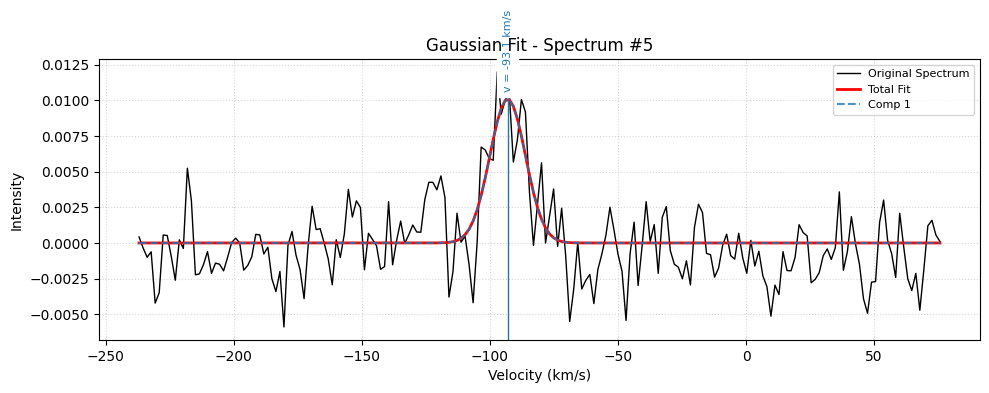

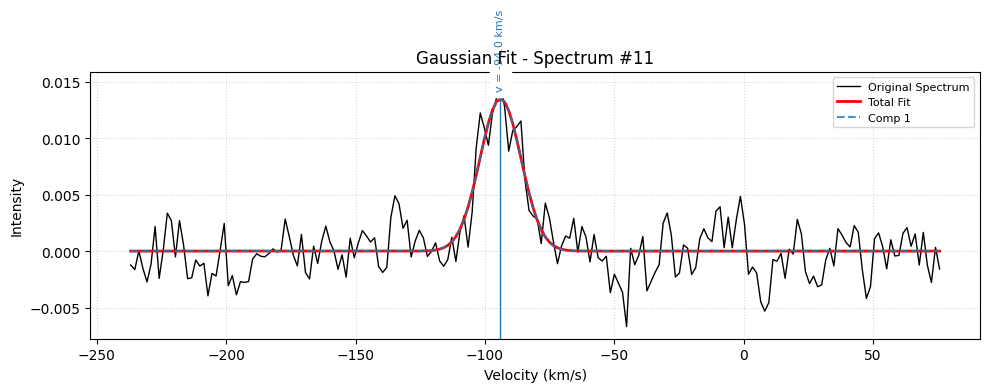

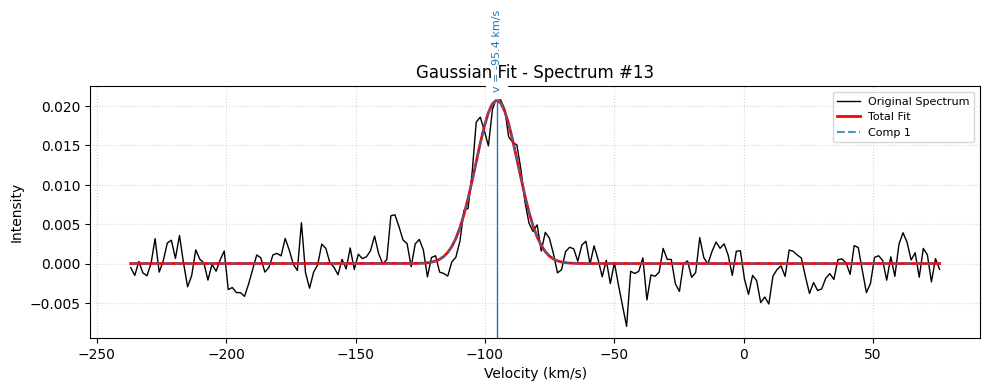

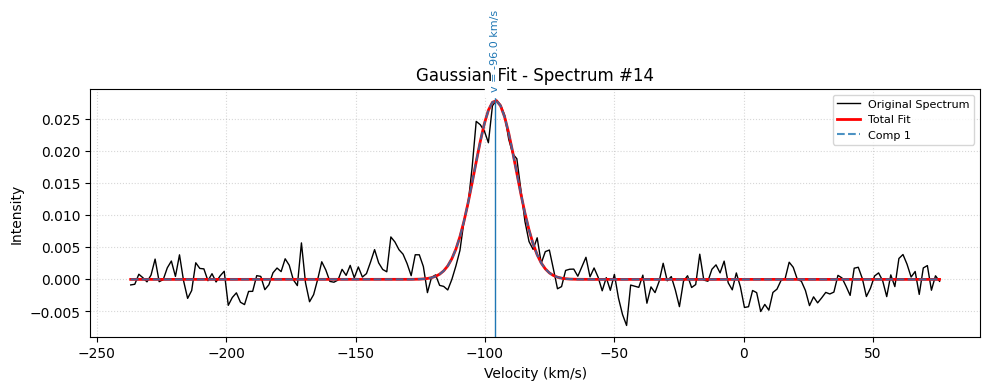

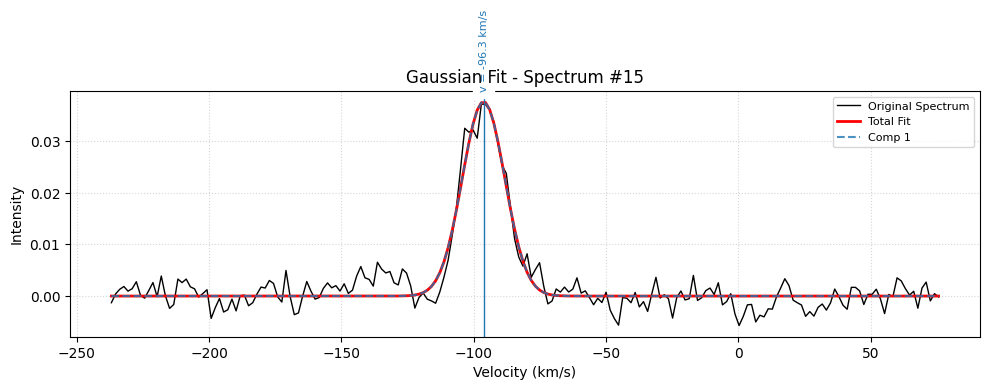

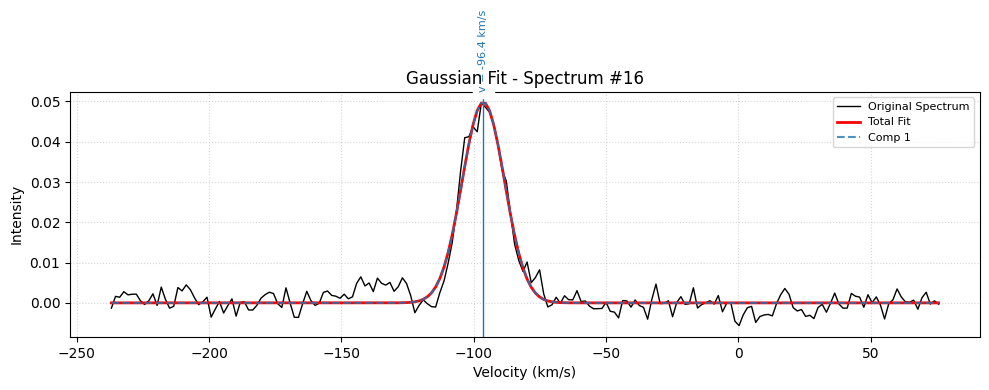

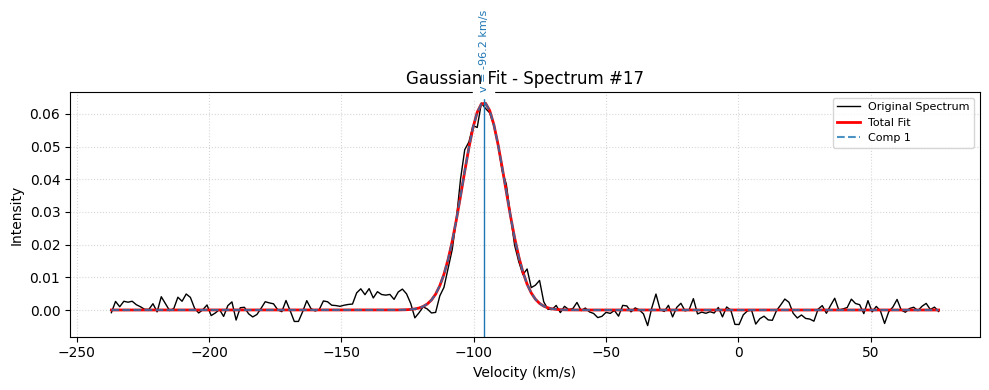

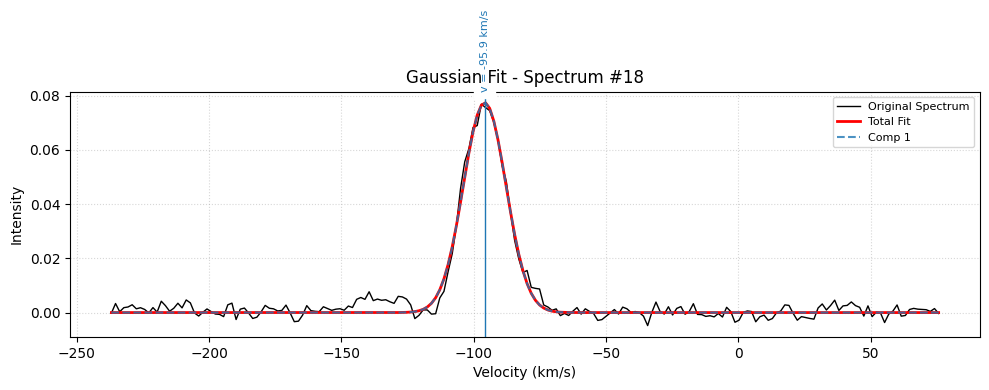

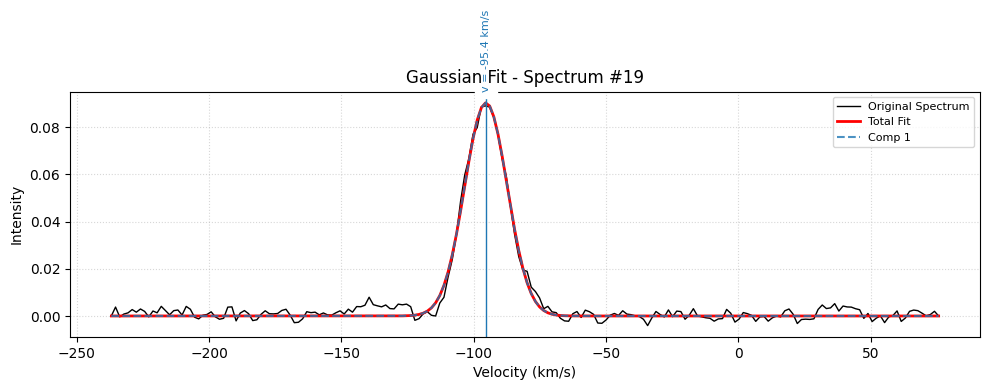

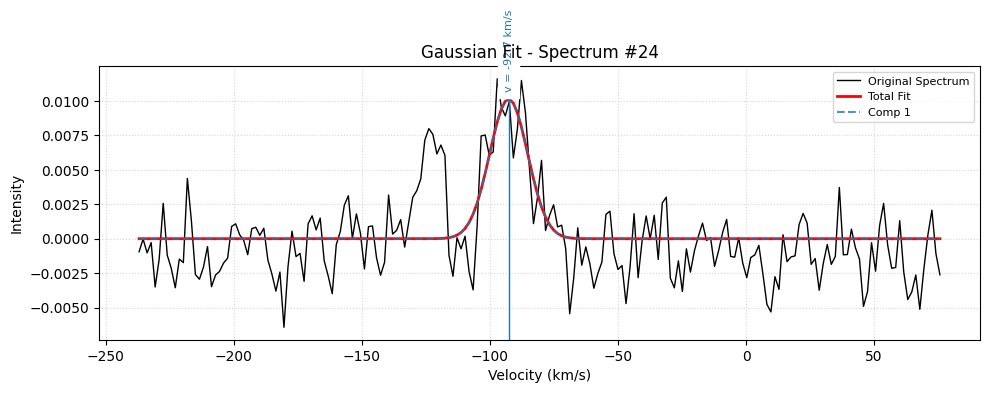

✅ 已繪製 10 條擬合成功的光譜（標記 peak velocity）


In [89]:
def plot_gausspy_fits(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    max_plots=None,
    dpi=100
):
    """
    一張一張畫出 GaussPy 擬合結果，標出每個高斯成分的 peak velocity。
    僅使用一般擬合結果（不含 EM fit）。
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']
    fwhms_all = result['fwhms_fit']

    n_result = len(amps_all)
    n_data = len(y_all)
    n_total = min(n_result, n_data)
    n_plotted = 0

    for i in range(n_total):
        if max_plots is not None and n_plotted >= max_plots:
            break

        amps = amps_all[i]
        means = means_all[i]
        fwhms = fwhms_all[i]

        if amps is None or len(amps) == 0:
            continue  # 擬合失敗，跳過

        x = x_all[i]
        y = y_all[i]
        stddevs = fwhms / (2 * np.sqrt(2 * np.log(2)))

        fit_total = np.zeros_like(x)
        gaussians = []

        for amp, mean, std in zip(amps, means, stddevs):
            gauss = amp * np.exp(-(x - mean)**2 / (2 * std**2))
            fit_total += gauss
            gaussians.append((gauss, mean, amp))

        # 繪圖
        plt.figure(figsize=(10, 4), dpi=dpi)
        plt.plot(x, y, color='black', lw=1, label='Original Spectrum')
        plt.plot(x, fit_total, color='red', lw=2, label='Total Fit')

        colors = plt.cm.tab10(np.linspace(0, 1, len(gaussians)))

        for j, (g, mean, amp) in enumerate(gaussians):
            plt.plot(x, g, linestyle='--', color=colors[j % 10], alpha=0.8, label=f'Comp {j+1}')
            plt.axvline(mean, color=colors[j % 10], linestyle='-', linewidth=1)
            plt.text(mean, amp * 1.05, f'v = {mean:.1f} km/s',
                     rotation=90, ha='center', va='bottom', fontsize=8,
                     color=colors[j % 10], backgroundcolor='white')

        plt.title(f'Gaussian Fit - Spectrum #{i}', fontsize=12)
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.legend(fontsize=8, loc='upper right')
        plt.tight_layout()
        plt.show()

        n_plotted += 1

    print(f"✅ 已繪製 {n_plotted} 條擬合成功的光譜（標記 peak velocity）")

plot_gausspy_fits(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    max_plots=10,  # 限制繪製前 10 條光譜
    dpi=100
)

In [90]:
def plot_gausspy_fits_all_restframe(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    max_plots=None,
    dpi=100
):
    """
    一張一張畫出 spectrum 的擬合結果，並將主成分 peak 對齊至 v = 0 km/s。
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']
    fwhms_all = result['fwhms_fit']

    n_result = len(amps_all)
    n_data = len(y_all)
    n_total = min(n_result, n_data)
    n_plotted = 0

    for i in range(n_total):
        if max_plots is not None and n_plotted >= max_plots:
            break

        amps = amps_all[i]
        means = means_all[i]
        fwhms = fwhms_all[i]

        if amps is None or len(amps) == 0:
            continue

        x_orig = x_all[i]
        y = y_all[i]

        # 取第一個成分的 peak velocity 當作 rest frame 參考
        v_peak = means[0]
        x_shifted = x_orig - v_peak
        means_shifted = [v - v_peak for v in means]

        stddevs = fwhms / (2 * np.sqrt(2 * np.log(2)))

        fit_total = np.zeros_like(x_orig)
        gaussians = []

        for amp, mean, std in zip(amps, means_shifted, stddevs):
            gauss = amp * np.exp(-(x_shifted - mean)**2 / (2 * std**2))
            fit_total += gauss
            gaussians.append((gauss, mean, amp))

        # 畫圖
        plt.figure(figsize=(10, 4), dpi=dpi)
        plt.plot(x_shifted, y, color='black', lw=1, label='Original Spectrum')
        plt.plot(x_shifted, fit_total, color='red', lw=2, label='Total Fit')

        colors = plt.cm.tab10(np.linspace(0, 1, len(gaussians)))

        for j, (g, mean, amp) in enumerate(gaussians):
            plt.plot(x_shifted, g, linestyle='--', color=colors[j % 10], alpha=0.8, label=f'Comp {j+1}')
            plt.axvline(mean, color=colors[j % 10], linestyle='-', linewidth=1)
            plt.text(mean, amp * 1.05, f'{mean:.1f} km/s',
                     rotation=90, ha='center', va='bottom', fontsize=8,
                     color=colors[j % 10], backgroundcolor='white')

        plt.title(f'Gaussian Fit (Rest Frame) - Spectrum #{i}', fontsize=12)
        plt.xlabel('Rest-frame Velocity (km/s)')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.legend(fontsize=8, loc='upper right')
        plt.tight_layout()
        plt.show()

        n_plotted += 1

    print(f"✅ 已繪製 {n_plotted} 條光譜（主 peak 對齊 v = 0 km/s）")

# plot_gausspy_fits_all_restframe(
#     data_pickle='spectrum_for_gausspy.pickle',
#     result_pickle='gausspy_result.pickle',
#     max_plots=10,  # 限制繪製前 10 條光譜
#     dpi=100
# )

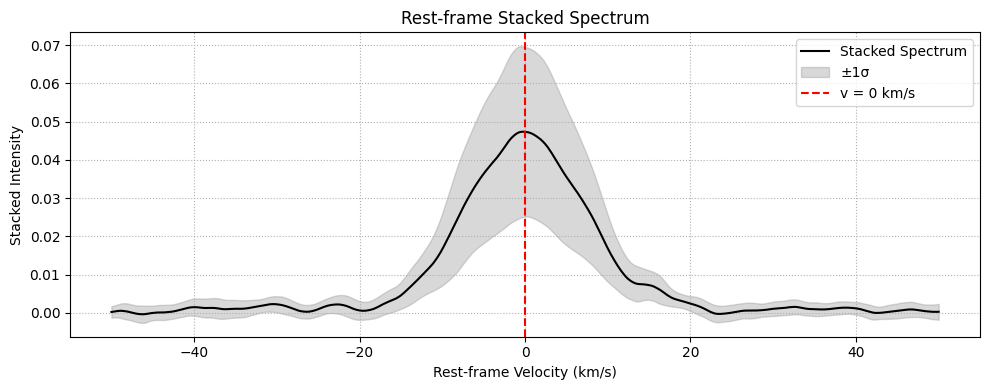

✅ 疊加完成：總光譜 400，成功使用 323 條（80.8%）


In [95]:
def stack_restframe_spectra(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    velocity_grid=None,
    v_range=(-50, 50),
    dv=0.2,
    normalize=False
):
    """
    疊加所有擬合成功的光譜，將主成分對齊至 v=0 km/s，提升 SNR。

    參數：
        data_pickle: 光譜資料（prepare_gausspy_input_per_pixel 的輸出）
        result_pickle: GaussPy 的分解結果（run_phase_two_gausspy_decomposition 的輸出）
        velocity_grid: 自訂統一速度軸（若為 None 則使用 v_range 與 dv 建立）
        v_range: 預設速度範圍 (km/s)，如 (-50, 50)
        dv: 速度解析度 (km/s)
        normalize: 是否正規化每條光譜再進行疊加（避免個別強度主導）

    回傳：
        v_grid: 速度軸 (km/s)
        mean_spec: 疊加平均光譜
        std_spec: 疊加標準差（1σ）
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d

    # === 讀入光譜與擬合資料 ===
    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']

    # === 定義統一速度軸 ===
    if velocity_grid is None:
        v_grid = np.arange(v_range[0], v_range[1] + dv, dv)
    else:
        v_grid = velocity_grid

    stacked = []
    used_indices = []

    for i, (x, y, amps, means) in enumerate(zip(x_all, y_all, amps_all, means_all)):
        if amps is None or len(amps) == 0 or means is None:
            continue

        # 使用最大 amplitude 對應的中心作為平移基準
        idx_peak = np.argmax(amps)
        v_peak = means[idx_peak]
        x_shifted = x - v_peak  # 主成分對齊到 v = 0

        try:
            f_interp = interp1d(x_shifted, y, kind='linear', bounds_error=False, fill_value=np.nan)
            y_interp = f_interp(v_grid)
            if normalize:
                y_interp = y_interp / np.nanmax(np.abs(y_interp))
            stacked.append(y_interp)
            used_indices.append(i)
        except Exception:
            continue  # 若插值錯誤則略過

    # === 疊加結果統計 ===
    stacked = np.array(stacked)
    mean_spec = np.nanmean(stacked, axis=0)
    std_spec = np.nanstd(stacked, axis=0)

    # === 繪圖 ===
    plt.figure(figsize=(10, 4))
    plt.plot(v_grid, mean_spec, label='Stacked Spectrum', color='black')
    plt.fill_between(v_grid, mean_spec - std_spec, mean_spec + std_spec, color='gray', alpha=0.3, label='±1σ')
    plt.axvline(0, linestyle='--', color='red', label='v = 0 km/s')
    plt.xlabel('Rest-frame Velocity (km/s)')
    plt.ylabel('Stacked Intensity')
    plt.title('Rest-frame Stacked Spectrum')
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === 訊息輸出 ===
    n_total = len(x_all)
    n_used = len(used_indices)
    print(f'✅ 疊加完成：總光譜 {n_total}，成功使用 {n_used} 條（{100 * n_used / n_total:.1f}%）')

    return v_grid, mean_spec, std_spec

stacked_v, stacked_mean, stacked_std = stack_restframe_spectra(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    v_range=(-50, 50),
    dv=0.2,
    normalize=False
)


/Users/ccc/opt/anaconda3/envs/gausspy/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
/Users/ccc/opt/anaconda3/envs/gausspy/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/ccc/opt/anaconda3/envs/gausspy/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


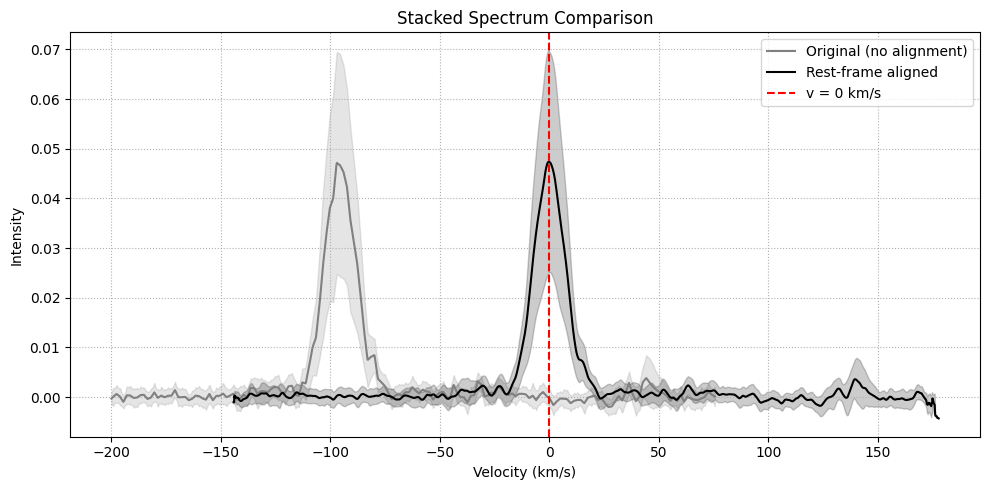

Stacking comparison complete. Used 323 spectra.


{'v_grid': array([-200. , -199.8, -199.6, ...,  199.6,  199.8,  200. ]),
 'mean_shifted': array([nan, nan, nan, ..., nan, nan, nan]),
 'std_shifted': array([nan, nan, nan, ..., nan, nan, nan]),
 'mean_direct': array([-0.00031665, -0.00022945, -0.00014225, ...,         nan,
                nan,         nan]),
 'std_direct': array([0.00119266, 0.00129207, 0.00145508, ...,        nan,        nan,
               nan])}

In [98]:
def compare_stack_with_without_shift(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    v_range=(-50, 50),
    dv=0.2,
    normalize=False
):
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d

    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']

    v_grid = np.arange(v_range[0], v_range[1] + dv, dv)

    stacked_shifted, stacked_direct = [], []
    used_count = 0

    for x, y, amps, means in zip(x_all, y_all, amps_all, means_all):
        if amps is None or means is None or len(amps) == 0:
            continue

        try:
            idx_peak = np.argmax(amps)
            v_peak = means[idx_peak]
            x_shifted = x - v_peak
            interp_shifted = interp1d(x_shifted, y, kind='linear', bounds_error=False, fill_value=np.nan)
            y_shifted = interp_shifted(v_grid)
            if normalize:
                y_shifted = y_shifted / np.nanmax(np.abs(y_shifted))
            stacked_shifted.append(y_shifted)

            interp_direct = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
            y_direct = interp_direct(v_grid)
            if normalize:
                y_direct = y_direct / np.nanmax(np.abs(y_direct))
            stacked_direct.append(y_direct)

            used_count += 1
        except Exception:
            continue

    stacked_shifted = np.array(stacked_shifted)
    stacked_direct = np.array(stacked_direct)

    mean_shifted = np.nanmean(stacked_shifted, axis=0)
    std_shifted = np.nanstd(stacked_shifted, axis=0)

    mean_direct = np.nanmean(stacked_direct, axis=0)
    std_direct = np.nanstd(stacked_direct, axis=0)

    plt.figure(figsize=(10, 5))
    plt.plot(v_grid, mean_direct, label='Original (no alignment)', color='gray', linestyle='-')
    plt.fill_between(v_grid, mean_direct - std_direct, mean_direct + std_direct, color='gray', alpha=0.2)

    plt.plot(v_grid, mean_shifted, label='Rest-frame aligned', color='black')
    plt.fill_between(v_grid, mean_shifted - std_shifted, mean_shifted + std_shifted, color='black', alpha=0.2)

    plt.axvline(0, linestyle='--', color='red', label='v = 0 km/s')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title('Stacked Spectrum Comparison')
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Stacking comparison complete. Used {used_count} spectra.")

    return {
        'v_grid': v_grid,
        'mean_shifted': mean_shifted,
        'std_shifted': std_shifted,
        'mean_direct': mean_direct,
        'std_direct': std_direct
    }
compare_stack_with_without_shift(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    v_range=(-200, 200),
    dv=0.2,
    normalize=False
)